### **Импортирование библиотек и данных**

In [ ]:
import time
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

In [ ]:
from ensembles import GradientBoostingMSE, RandomForestMSE

## **Обработка данных**

In [ ]:
from sklearn.model_selection import train_test_split

data = pd.read_csv('kc_house_data.csv')

X = data.drop(columns=['price'])
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.head(5)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
6325,5467910190,20140527T000000,3,1.75,1780,13095,1.0,0,0,4,9,1780,0,1983,0,98042,47.3670,-122.152,2750,13095
13473,9331800580,20150310T000000,2,1.00,1000,3700,1.0,0,0,3,6,800,200,1929,0,98118,47.5520,-122.290,1270,5000
17614,2407000405,20150226T000000,3,1.00,1080,7486,1.5,0,0,3,6,990,90,1942,0,98146,47.4838,-122.335,1170,7800
16970,5466700290,20150108T000000,3,2.25,2090,7500,1.0,0,0,4,7,1280,810,1977,0,98031,47.3951,-122.172,1800,7350
20868,3026059361,20150417T000000,2,2.50,1741,1439,2.0,0,0,3,8,1446,295,2007,0,98034,47.7043,-122.209,2090,10454


In [ ]:
for column in X_train.columns:
  print(f"{column}: {X_train[column].nunique()}")

id: 17178
date: 368
bedrooms: 12
bathrooms: 29
sqft_living: 923
sqft_lot: 8406
floors: 6
waterfront: 2
view: 5
condition: 5
grade: 12
sqft_above: 842
sqft_basement: 288
yr_built: 116
yr_renovated: 70
zipcode: 70
lat: 4846
long: 724
sqft_living15: 710
sqft_lot15: 7558


## **Изучение признаков**

### **Обработка выбросов цены квартиры**

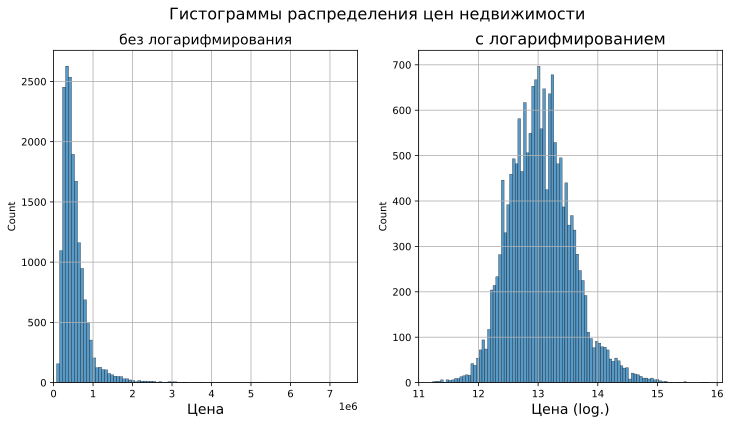

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

fig.suptitle("Гистограммы распределения цен недвижимости", fontsize=16)

ax = axes[0]
sns.histplot(y_train, bins=100 ,ax=ax)
ax.set_title("без логарифмирования", fontsize=14)
ax.set_xlabel("Цена", fontsize=14)

ax.set_xlim((0, y_train.max()))
ax.grid()

ax = axes[1]
sns.histplot(np.log(y_train), bins=100 ,ax=ax)
ax.set_title("с логарифмированием", fontsize=16)
ax.set_xlabel("Цена (log.)", fontsize=14)

ax.grid()

fig.savefig("cost.pdf")
plt.show()

Квантиль 99.9-й - 3331995.0000001336


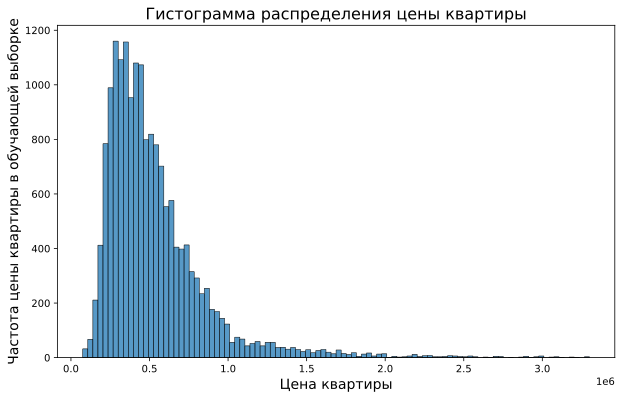

In [ ]:
q_score99 = y_train.quantile(0.999)
print(f"Квантиль 99.9-й - {q_score99}")

plt.figure(figsize=(10, 6))
sns.histplot(y_train[y_train <= q_score99], bins=100)
plt.title("Гистограмма распределения цены квартиры", fontsize=16)
plt.xlabel("Цена квартиры", fontsize=14)
plt.ylabel("Частота цены квартиры в обучающей выборке", fontsize=14)

plt.show()

In [ ]:
# X_train = X_train[y_train <= q_score99]
# y_train = y_train[y_train <= q_score99]

Уберем все данные из обучения, у которых цена квартиры больше 99.9 квантиля.

Выбор данного квантиля обусловлен тем, что есть слишком дорогостоящие квартиры, которых всего около 17.

### **Общее описание признаков в таблице**

In [ ]:
for column in X_train.columns:
  print(f"{column}: {X_train[column].nunique()}")

id: 17178
date: 368
bedrooms: 12
bathrooms: 29
sqft_living: 923
sqft_lot: 8406
floors: 6
waterfront: 2
view: 5
condition: 5
grade: 12
sqft_above: 842
sqft_basement: 288
yr_built: 116
yr_renovated: 70
zipcode: 70
lat: 4846
long: 724
sqft_living15: 710
sqft_lot15: 7558


Описание признаков:
1. id (17160) - не используем.
2. date (368) - даты, можно обработать.
3. bedrooms (12) - количество спален. Категориальный.
4. bathrooms (26) - размер ванных комнат (?). Численный.
5. sqft_living (912) - размер жилой площади в квадратных футах. Численный.
6. sqft_lot (8393) - размер участка в квадратных футах. Численный.
7. floors (6) - количество этажей. Категориальный.
8. waterfront (2) - дом расположен на набережной. Категориальный.
9. view (5) - количество видов из дома(?). Категориальный.
10. condition (5) - состояние дома (от 1 до 5). Категориальный.
11. grade (12) - класс дома. Категориальный.
12. sqft_above (835) - размер жилой площади дома (без подвала) в квадратных футах.
13. sqft_basement (282) - размер подвала в квадратных футах. Численный.
14. yr_built (116) - год постройки. Численный. (надо изучить)
15. yr_renovated (70) - год реновации. Численный (надо изучить)
16. zipcode (70) - почтовый индекс. (можно использовать, как аналог для квадратов из lat и long).
17. lat (4846), long (724) - ширина, долгота расположения. Используем для получения признака house_rectangle.
19. sqft_living15 (708) - средняя жилая площадь 15 объектов поблизости в квадратных футах. Численный (отнимем жилую площадь самого дома и возьмем модуль, получив отклонение)
20. sqft_lot15 (7546) - средний размер участка 15 объектов поблизости в квадратных футах. Численный (отнимем жилую площадь самого дома и возьмем модуль, получив отклонение)


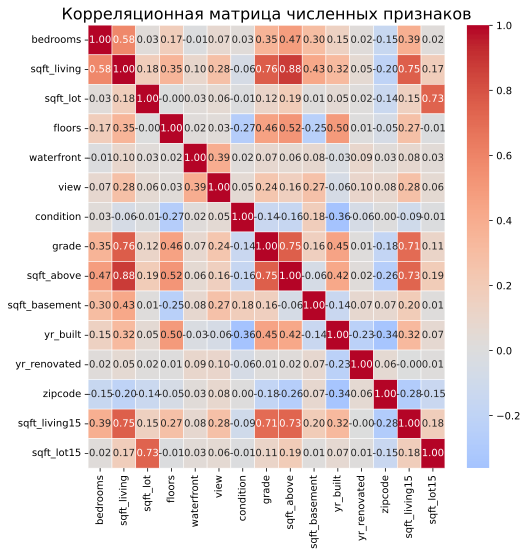

In [ ]:
correlations = X_train[["bedrooms", "sqft_living", "sqft_lot",
                         "floors", "waterfront", "view",
                         "condition", "grade", "sqft_above",
                         "sqft_basement", "yr_built", "yr_renovated",
                         "zipcode", "sqft_living15", "sqft_lot15"]].corr()

fig = plt.figure(figsize=(8, 8))

sns.heatmap(correlations, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5)
plt.title('Корреляционная матрица численных признаков', fontsize=16)

fig.savefig("corr1.pdf")
plt.show()

Обработаем sqft_leaving15, sqft_lot15. Удалим признак sqft_above (так как он является разницой между жилой площадью и площадью подвала).

In [ ]:
X_train['dev_living15'] = X_train['sqft_living15'] - X_train['sqft_living']
X_train = X_train.drop(columns=['sqft_living15'])

X_train['dev_lot15'] = X_train['sqft_lot15'] - X_train['sqft_lot']
X_train = X_train.drop(columns=['sqft_lot15'])

X_train = X_train.drop(columns=['sqft_above'])

X_test['dev_living15'] = X_test['sqft_living15'] - X_test['sqft_living']
X_test = X_test.drop(columns=['sqft_living15'])

X_test['dev_lot15'] = X_test['sqft_lot15'] - X_test['sqft_lot']
X_test = X_test.drop(columns=['sqft_lot15'])

X_test = X_test.drop(columns=['sqft_above'])

In [ ]:
X_train.head(10)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,dev_living15,dev_lot15
6325,5467910190,20140527T000000,3,1.75,1780,13095,1.0,0,0,4,9,0,1983,0,98042,47.3670,-122.152,970,0
13473,9331800580,20150310T000000,2,1.00,1000,3700,1.0,0,0,3,6,200,1929,0,98118,47.5520,-122.290,270,1300
17614,2407000405,20150226T000000,3,1.00,1080,7486,1.5,0,0,3,6,90,1942,0,98146,47.4838,-122.335,90,314
16970,5466700290,20150108T000000,3,2.25,2090,7500,1.0,0,0,4,7,810,1977,0,98031,47.3951,-122.172,-290,-150
20868,3026059361,20150417T000000,2,2.50,1741,1439,2.0,0,0,3,8,295,2007,0,98034,47.7043,-122.209,349,9015
8993,1523069096,20140811T000000,3,1.75,2340,51836,1.5,0,0,3,8,830,1978,0,98027,47.4846,-122.035,-280,25700
10432,3876312010,20140603T000000,5,2.75,2040,7488,1.0,0,0,4,7,840,1969,0,98034,47.7289,-122.172,-510,0
10163,8832900135,20150113T000000,5,2.25,3320,13138,1.0,0,2,4,9,1420,1964,0,98028,47.7590,-122.269,-500,0
17889,9238900616,20140610T000000,3,1.75,1760,8400,1.0,0,0,4,8,300,1960,0,98136,47.5355,-122.390,220,0
13246,4142450040,20150327T000000,3,2.50,1610,5024,2.0,0,0,3,7,0,2004,0,98038,47.3833,-122.043,180,-1307


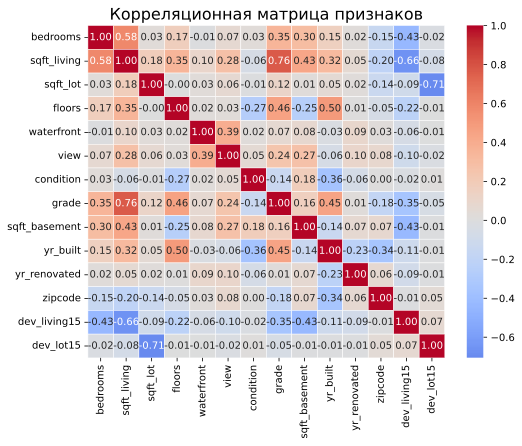

In [ ]:
correlations = X_train[["bedrooms", "sqft_living", "sqft_lot",
                         "floors", "waterfront", "view", "condition",
                         "grade", "sqft_basement", "yr_built", "yr_renovated",
                         "zipcode", "dev_living15", "dev_lot15"]].corr()

fig = plt.figure(figsize=(8, 6))

sns.heatmap(correlations, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5)
plt.title('Корреляционная матрица признаков', fontsize=16)


fig.savefig("corr2.pdf")

plt.show()

### **Обработка колонки с датами**

Обрабатываем колонку date. Разделим все даты, встречающиеся в обучающей выборке на 20 диапазонов по равной частоте.

In [ ]:
X_train['date'] = pd.to_datetime(X_train['date'], format="%Y%m%dT%H%M%S")

X_test['date'] = pd.to_datetime(X_test['date'], format="%Y%m%dT%H%M%S")

In [ ]:
train_min_date = X_train['date'].min()

X_train['date'] = (X_train['date'] - train_min_date).dt.days

X_train['date'], bin_edges = pd.qcut(X_train['date'], q=20, retbins=True, labels=range(1, 21))

X_test['date'] = (X_test['date'] - train_min_date).dt.days
X_test['date'] = pd.cut(X_test['date'], bins=bin_edges, labels=range(1, 21), include_lowest=True)

X_test['date'] = X_test['date'].fillna(method='pad').fillna(method='bfill')

<ipython-input-15-af622f2b68db>:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_test['date'] = X_test['date'].fillna(method='pad').fillna(method='bfill')


In [ ]:
X_train.head(5)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,dev_living15,dev_lot15
6325,5467910190,2,3,1.75,1780,13095,1.0,0,0,4,9,0,1983,0,98042,47.3670,-122.152,970,0
13473,9331800580,16,2,1.00,1000,3700,1.0,0,0,3,6,200,1929,0,98118,47.5520,-122.290,270,1300
17614,2407000405,16,3,1.00,1080,7486,1.5,0,0,3,6,90,1942,0,98146,47.4838,-122.335,90,314
16970,5466700290,14,3,2.25,2090,7500,1.0,0,0,4,7,810,1977,0,98031,47.3951,-122.172,-290,-150
20868,3026059361,19,2,2.50,1741,1439,2.0,0,0,3,8,295,2007,0,98034,47.7043,-122.209,349,9015


Обработаем признаки yr_built и yr_renovated.

In [ ]:
X_train.head(5)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,dev_living15,dev_lot15
6325,5467910190,2,3,1.75,1780,13095,1.0,0,0,4,9,0,1983,0,98042,47.3670,-122.152,970,0
13473,9331800580,16,2,1.00,1000,3700,1.0,0,0,3,6,200,1929,0,98118,47.5520,-122.290,270,1300
17614,2407000405,16,3,1.00,1080,7486,1.5,0,0,3,6,90,1942,0,98146,47.4838,-122.335,90,314
16970,5466700290,14,3,2.25,2090,7500,1.0,0,0,4,7,810,1977,0,98031,47.3951,-122.172,-290,-150
20868,3026059361,19,2,2.50,1741,1439,2.0,0,0,3,8,295,2007,0,98034,47.7043,-122.209,349,9015


In [ ]:
X_train['yr_built'] = (2015 - X_train['yr_built'])
X_train.loc[X_train['yr_renovated'] != 0, 'yr_renovated'] = (2015 - X_train.loc[X_train['yr_renovated'] != 0, 'yr_renovated'])

X_test['yr_built'] = (2015 - X_test['yr_built'])
X_test.loc[X_test['yr_renovated'] != 0, 'yr_renovated'] = (2015 - X_test.loc[X_test['yr_renovated'] != 0, 'yr_renovated'])

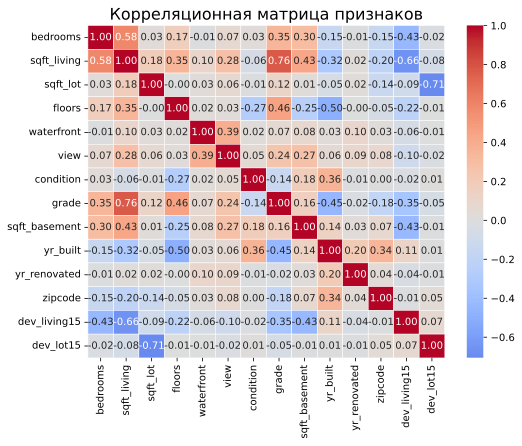

In [ ]:
correlations = X_train[["bedrooms", "sqft_living", "sqft_lot",
                         "floors", "waterfront", "view", "condition",
                         "grade", "sqft_basement", "yr_built", "yr_renovated",
                         "zipcode", "dev_living15", "dev_lot15"]].corr()

fig = plt.figure(figsize=(8, 6))

sns.heatmap(correlations, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5)
plt.title('Корреляционная матрица признаков', fontsize=16)

fig.savefig("corr3.pdf")
plt.show()

### **Обработка колонок 'lat' и 'long'**

Эти две колонки можно объединить в одну 'rectangle', как мы делали в первом практическом задании по ММРО. Таким образом, можно получить информативный признак о расположении квартир.

In [ ]:
import folium

def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.

    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class MapGridTransformer(BaseEstimator, TransformerMixin):
  def __init__(self, count_rectangles: int = 50, count_columns: int = 15,
               count_rows: int = 15):
    # количество прямоугольников после обучения
    self.count_rectangles = count_rectangles
    # количество строк из прямоугольников
    self.count_rows = count_rows
    # количество столбцов из прямоугольников
    self.count_columns = count_columns

    # обучаемые параметры
    self.max_longitude = None
    self.min_longitude = None
    self.max_latitude = None
    self.max_latitude = None
    self.weight = None
    self.height = None

    # словарь, где ключ = номер прямоугольника, значение = лист из двух координат.
    self.max_rectangles_dict = None
    self.max_index_dict = None

  def fit(self, data: pd.DataFrame):
    if (not ('lat' in data.columns)) or (not ('long' in data.columns)):
      raise ValueError("Нет координат, отвечающих за начало поездки")
    latitude = data['lat']
    longitude = data['long']

    self.location = (latitude.mean(), longitude.mean())
    self.max_longitude = longitude.max()
    self.min_longitude = longitude.min()
    self.max_latitude = latitude.max()
    self.min_latitude = latitude.min()

    # северно-западный угол = (max_latitude, max_longitude)
    # юго-востоный угол = (min_latitude, min_longitude)
    self.weight = (self.max_longitude - self.min_longitude)/self.count_columns
    self.height = (self.max_latitude - self.min_latitude)/self.count_rows

    latitude = latitude - self.max_latitude
    latitude = latitude * (-1)
    n_latitude = (latitude / self.height).apply(int)

    longitude = longitude - self.min_longitude
    n_longitude = (longitude / self.weight).apply(int)

    numers_vector = n_latitude * self.count_columns + n_longitude
    counts = numers_vector.value_counts().head(self.count_rectangles)

    indexes = counts.index
    num_rows = indexes // self.count_columns
    num_columns = indexes - num_rows * self.count_columns

    i_nw_latitude = num_rows * (-self.height) + self.max_latitude
    i_nw_longitude = (num_columns + 1) * self.weight + self.min_longitude
    i_se_latitude = (num_rows + 1) * (-self.height) + self.max_latitude
    i_se_longitude = num_columns * self.weight + self.min_longitude

    self.max_rectangles_dict = dict()
    for index, nw_lat, nw_long, se_lat, se_long in zip(indexes, i_nw_latitude, i_nw_longitude, i_se_latitude, i_se_longitude):
      self.max_rectangles_dict[index] = ((nw_lat, nw_long), (se_lat, se_long))

    self.max_index_dict = dict()
    for i, index in enumerate(indexes):
      self.max_index_dict[index] = i


  def transform(self, data: pd.DataFrame):

    if not ('lat' in data.columns) or not ('long' in data.columns):
      raise ValueError("Нет координат, отвечающих за начало поездки")

    transformed_data = data.copy()
    # вычисления для pickup
    latitude = data['lat']
    longitude = data['long']

    latitude = latitude - self.max_latitude
    latitude = latitude * (-1)
    n_latitude = (latitude / self.height).apply(int)

    longitude = longitude - self.min_longitude
    n_longitude = (longitude / self.weight).apply(int)

    numers_vector = n_latitude * self.count_columns + n_longitude

    transformed_data['house_rectangle'] = numers_vector.map(lambda x: self.max_index_dict.get(x, -1))

    return transformed_data

  def visualize(self):
    if self.max_rectangles_dict is None:
      raise ValueError("Трансформеру нечего визуализировать")
    m = folium.Map(location=self.location)
    for point in self.max_rectangles_dict.values():
        folium.Rectangle(bounds=point, color='red').add_to(m)
    return m

In [ ]:
transformer = MapGridTransformer()
transformer.fit(X_train)
transformer.visualize()

In [ ]:
X_train = transformer.transform(X_train)
X_train.drop(columns=['lat', 'long'], inplace=True)

X_test = transformer.transform(X_test)
X_test.drop(columns=['lat', 'long'], inplace=True)

In [ ]:
X_train.head(5)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,dev_living15,dev_lot15,house_rectangle
6325,5467910190,2,3,1.75,1780,13095,1.0,0,0,4,9,0,32,0,98042,970,0,19
13473,9331800580,16,2,1.00,1000,3700,1.0,0,0,3,6,200,86,0,98118,270,1300,10
17614,2407000405,16,3,1.00,1080,7486,1.5,0,0,3,6,90,73,0,98146,90,314,28
16970,5466700290,14,3,2.25,2090,7500,1.0,0,0,4,7,810,38,0,98031,-290,-150,19
20868,3026059361,19,2,2.50,1741,1439,2.0,0,0,3,8,295,8,0,98034,349,9015,15


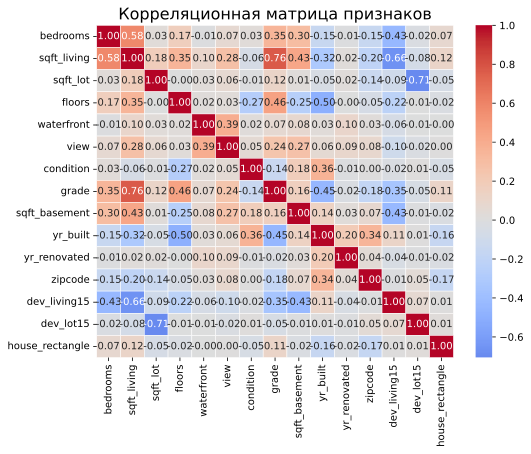

In [ ]:
correlations = X_train[["bedrooms", "sqft_living", "sqft_lot",
                         "floors", "waterfront", "view", "condition",
                         "grade", "sqft_basement", "yr_built", "yr_renovated",
                         "zipcode", "dev_living15", "dev_lot15", "house_rectangle"]].corr()

fig = plt.figure(figsize=(8, 6))

sns.heatmap(correlations, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5)
plt.title('Корреляционная матрица признаков', fontsize=16)

fig.savefig("corr4.pdf")
plt.show()

In [ ]:
from collections import defaultdict

class MeanTargetEncoder(BaseEstimator, TransformerMixin):
  def __init__(self, rand_coef = 0.01):
    self.rand_coef = rand_coef
    self._dict_feature = None

  def get_feature_names_out(self, input_features):
    return input_features

  def fit(self, X, y):
    np.random.seed(42)
    self._dict_feature = {}

    for feature_name in X.columns:
      self._dict_feature[feature_name] = {}

      for feature in X[feature_name].unique():
        noise = np.random.normal(0, self.rand_coef)

        self._dict_feature[feature_name][feature] = y[X[feature_name] == feature].sum() /((X[feature_name] == feature).sum()) + noise


  def transform(self, X):
    Z = X.copy(deep=False)
    for feature_name in Z.columns:
      if feature_name not in self._dict_feature:
        raise ValueError(f"Transform не может быть применим к колонке {feature_name}")

      for feature in Z[feature_name].unique():
        if feature in self._dict_feature[feature_name]:
          Z[feature_name] = pd.to_numeric(Z[feature_name], errors='coerce').astype('float64')
          Z.loc[X[feature_name] == feature, feature_name] = self._dict_feature[feature_name][feature]
        else:
          raise ValueError(f"MeanTargetEncoder не применим к колонке {feature_name} и её значением ")

    return Z

  def fit_transform(self, X, y):
    self.fit(X, y)
    return self.transform(X)

In [ ]:
categorial_features = ["date", "bedrooms", "floors", 	"waterfront", "view",
                       "condition", "grade", "zipcode", "house_rectangle"]

meantarget_features = ["zipcode", "grade"]

onehot_features = ["date", "bedrooms", "waterfront", "view",
                   "condition", "house_rectangle", "floors" ]

scalar_features = ["bathrooms", "sqft_living",  "sqft_lot", "sqft_basement",
                   "yr_built", "yr_renovated", "dev_living15", 	"dev_lot15"]

In [ ]:
# некоторые категориальные признаки будут закодированы onehotencoder-ом
# оставшиеся targetencoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('scalar', StandardScaler(), scalar_features),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), onehot_features),
        ('target', MeanTargetEncoder(), meantarget_features)
    ]
)

In [ ]:
print(y_train.min(), y_train.max())

75000.0 7700000.0


In [ ]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [ ]:
print(X_test.isna().sum())

id                 0
date               0
bedrooms           0
bathrooms          0
sqft_living        0
sqft_lot           0
floors             0
waterfront         0
view               0
condition          0
grade              0
sqft_basement      0
yr_built           0
yr_renovated       0
zipcode            0
dev_living15       0
dev_lot15          0
house_rectangle    0
dtype: int64


In [ ]:
preprocessor.fit(X_train, y_train)
X_train_t = preprocessor.transform(X_train)
X_test_t = preprocessor.transform(X_test)

Разделим на обучающую и валидационную выборку.

In [ ]:
from sklearn.model_selection import train_test_split

X_train1, X_val, y_train1, y_val = train_test_split(
    X_train_t, y_train, test_size=0.2, random_state=42
)

print("Размер обучающей выборки:", X_train1.shape, y_train1.shape)
print("Размер валидационной выборки:", X_val.shape, y_val.shape)

Размер обучающей выборки: (13832, 111) (13832,)
Размер валидационной выборки: (3458, 111) (3458,)


## **Исследование случайного леса в зависимости от гиперпараметров**

Начнем перебирать параметры следующим образом. Разобьем обучающую выборку на обучающую и валидационной в отношении 1 к 9. На валидационной мы будем подбирать гиперпараметры. Подбирать гиперпараметры будем с помощью GridSearch.

1. max_features: "sqrt", "log2", X.shape[1]/3.
2. max_depth: 2, 3, 4, 5, 10. (отдельно случай c None).
3. n_estimators: 10, 50, 100.

In [ ]:
model = RandomForestMSE(n_estimators=10000, tree_params={"max_depth": 3})

history = model.fit(X_train1, y_train1, X_val=X_val, y_val=y_val)

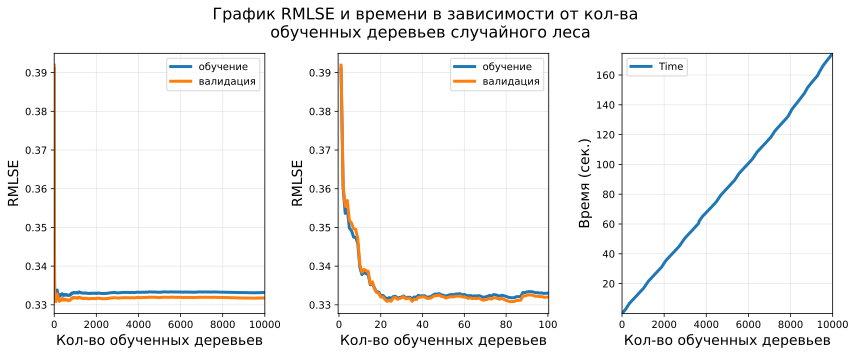

In [ ]:
val_data = np.array(history['val'])
train_data = np.array(history['train'])
time_data = np.array(history['time'])

count_trees = range(1, len(val_data) + 1)

fig, axes = plt.subplots(1, 3, figsize=(12, 5))

fig.suptitle("График RMLSE и времени в зависимости от кол-ва \n обученных деревьев случайного леса", fontsize=16)
ax = axes[0]
ax.plot(count_trees, train_data, label='обучение', linewidth=3)
ax.plot(count_trees, val_data, label='валидация', linewidth=3)

ax.set_xlabel('Кол-во обученных деревьев', fontsize=14)
ax.set_ylabel('RMLSE', fontsize=14)

ax.set_xlim((-0.4, len(time_data) + 0.4))

ax.legend()
ax.grid(alpha=0.3)

ax = axes[1]
ax.plot(count_trees, train_data, label='обучение', linewidth=3)
ax.plot(count_trees, val_data, label='валидация', linewidth=3)

ax.set_xlabel('Кол-во обученных деревьев', fontsize=14)
ax.set_ylabel('RMLSE', fontsize=14)

ax.set_xlim((-0.4, 100 + 0.4))

ax.legend()
ax.grid(alpha=0.3)

ax = axes[2]
ax.plot(count_trees, time_data, label='Time', linewidth=3)

ax.set_xlabel('Кол-во обученных деревьев', fontsize=14)
ax.set_ylabel('Время (сек.)', fontsize=14)
ax.set_ylim((time_data.min(),time_data.max()))
ax.set_xlim((-0.4, len(time_data) + 0.4))
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()

fig.savefig("n_estim.pdf")
plt.show()

### **Исследование в зависимости от гиперпараметра max_features**

In [ ]:
from tqdm import tqdm

max_features_history = {}

for max_features in tqdm(["sqrt", "log2", int(X_train_t.shape[1]/2), int(X_train_t.shape[1]/3), 10, 5, 2]):
  model = RandomForestMSE(n_estimators=10000, tree_params={
      "max_depth": 3, "max_features": max_features})

  index = str(max_features)

  max_features_history[index] = model.fit(X_train1, y_train1, patience=2000, X_val=X_val, y_val=y_val)

100%|██████████| 7/7 [05:57<00:00, 51.11s/it]


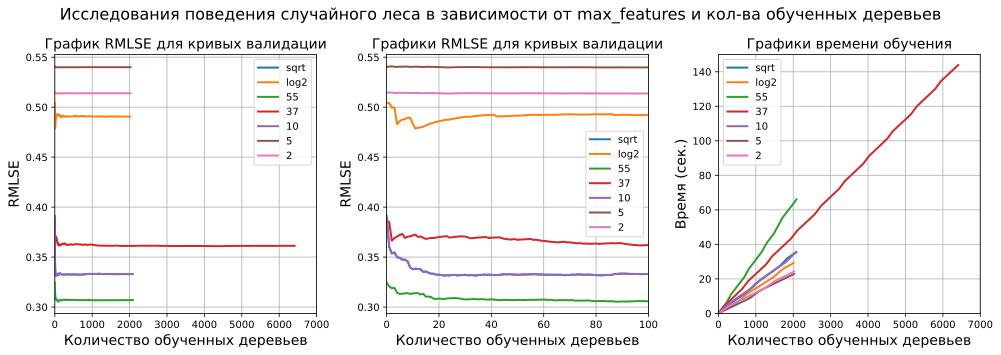

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

fig.suptitle("Исследования поведения случайного леса в зависимости от max_features и кол-ва обученных деревьев", fontsize=16)
ax = axes[0]
ax.set_title("График RMLSE для кривых валидации", fontsize=14)

for index in max_features_history.keys():
  ax.plot(max_features_history[index]['train'], linewidth=2, label=index)

ax.set_xlabel("Количество обученных деревьев", fontsize=14)
ax.set_ylabel("RMLSE", fontsize=14)

ax.set_xlim((0, 7000))
ax.legend()
ax.grid()

ax = axes[1]
ax.set_title("Графики RMLSE для кривых валидации", fontsize=14)

for index in max_features_history.keys():
  ax.plot(max_features_history[index]['train'], linewidth=2, label=index)

ax.set_xlabel("Количество обученных деревьев", fontsize=14)
ax.set_ylabel("RMLSE", fontsize=14)
ax.set_xlim((0 ,100))
# ax.set_ylim((0.16, 0.19))
ax.legend()
ax.grid()

ax = axes[2]
ax.set_title("Графики времени обучения", fontsize=14)

for index in max_features_history.keys():
  ax.plot(max_features_history[index]['time'], linewidth=2, label=index)

ax.set_xlabel("Количество обученных деревьев", fontsize=14)
ax.set_ylabel("Время (сек.)", fontsize=14)

ax.set_xlim((0, 7000))
ax.set_ylim((0, 150))
ax.legend()
ax.grid()

fig.savefig(fname='rf_mf.pdf')

plt.tight_layout()
plt.show()

### **Исследование в зависимости от гиперпараметра max_depth**

In [ ]:
from tqdm import tqdm

max_depth_history = {}

for max_depth in tqdm([2, 3, 4, 5, 10]):
  model = RandomForestMSE(n_estimators=10000, tree_params={
      "max_depth": max_depth})

  index = str(max_depth)

  max_depth_history[index] = model.fit(X_train_t, y_train, patience=2000, X_val=X_test_t, y_val=y_test)

100%|██████████| 5/5 [05:17<00:00, 63.56s/it]


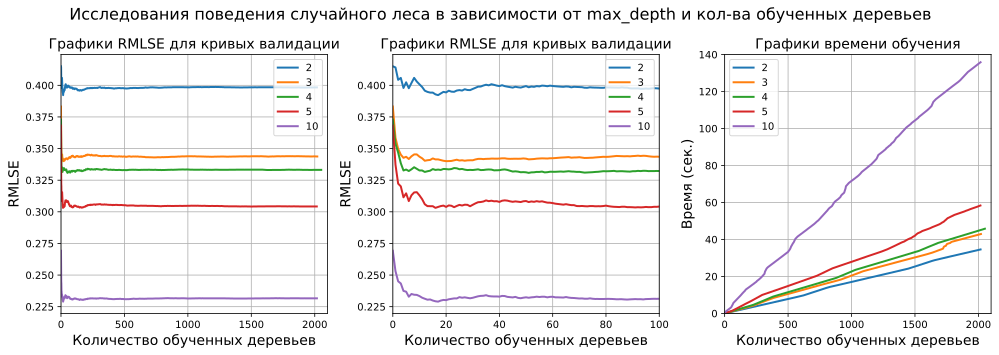

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

fig.suptitle("Исследования поведения случайного леса в зависимости от max_depth и кол-ва обученных деревьев", fontsize=16)

ax = axes[0]
ax.set_title("Графики RMLSE для кривых валидации", fontsize=14)

for index in max_depth_history.keys():
  ax.plot(max_depth_history[index]['val'], linewidth=2, label=index)

ax.set_xlabel("Количество обученных деревьев", fontsize=14)
ax.set_ylabel("RMLSE", fontsize=14)
ax.set_xlim((0, 2100))
ax.legend()
ax.grid()

ax = axes[1]
ax.set_title("Графики RMLSE для кривых валидации", fontsize=14)

for index in max_depth_history.keys():
  ax.plot(max_depth_history[index]['val'], linewidth=2, label=index)

ax.set_xlabel("Количество обученных деревьев", fontsize=14)
ax.set_ylabel("RMLSE", fontsize=14)
ax.set_xlim((0 ,100))

ax.legend()
ax.grid()

ax = axes[2]
ax.set_title("Графики времени обучения", fontsize=14)

for index in max_depth_history.keys():
  ax.plot(max_depth_history[index]['time'], linewidth=2, label=index)

ax.set_xlabel("Количество обученных деревьев", fontsize=14)
ax.set_ylabel("Время (сек.)", fontsize=14)

ax.set_xlim((0, 2100))
ax.set_ylim((0, 140))
ax.legend()
ax.grid()

plt.savefig(fname='rf_md.pdf')

plt.tight_layout()
plt.show()

### **Исследование при неограниченной глубине деревьев**

In [ ]:
model = RandomForestMSE(n_estimators=10000, tree_params={
    "max_depth": None})

none_depth = model.fit(X_train_t, y_train, patience=2000, X_val=X_test_t, y_val=y_test)

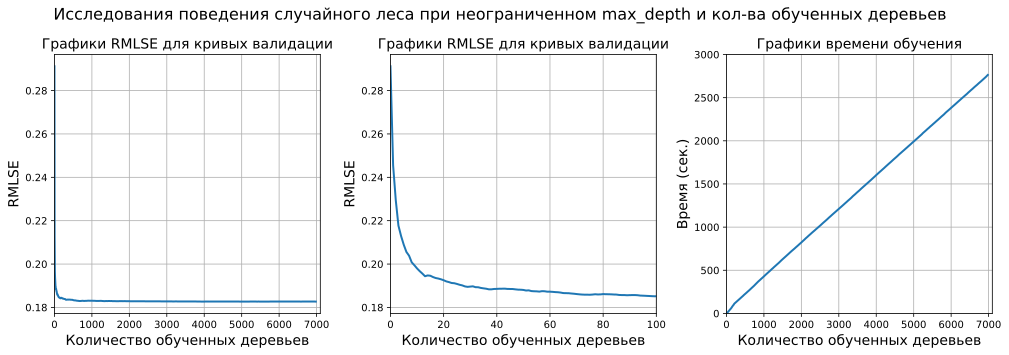

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

fig.suptitle("Исследования поведения случайного леса при неограниченном max_depth и кол-ва обученных деревьев", fontsize=16)

ax = axes[0]
ax.set_title("Графики RMLSE для кривых валидации", fontsize=14)

ax.plot(none_depth['val'], linewidth=2, label=index)

ax.set_xlabel("Количество обученных деревьев", fontsize=14)
ax.set_ylabel("RMLSE", fontsize=14)
ax.set_xlim((0, 7100))

ax.grid()

ax = axes[1]
ax.set_title("Графики RMLSE для кривых валидации", fontsize=14)

ax.plot(none_depth['val'], linewidth=2, label=index)

ax.set_xlabel("Количество обученных деревьев", fontsize=14)
ax.set_ylabel("RMLSE", fontsize=14)
ax.set_xlim((0 ,100))

ax.grid()

ax = axes[2]
ax.set_title("Графики времени обучения", fontsize=14)

ax.plot(none_depth['time'], linewidth=2, label=index)

ax.set_xlabel("Количество обученных деревьев", fontsize=14)
ax.set_ylabel("Время (сек.)", fontsize=14)

ax.set_xlim((0, 7100))
ax.set_ylim((0, 3000))
ax.grid()

plt.savefig(fname='rf_nmd.pdf')

plt.tight_layout()
plt.show()

## **Исследование градиентного бустинга в зависимости от гиперпараметров**

Подбирать параметры будем с помощью перебора по следующим гиперпараметрам:
1. **n_estimators**: установим 10000 (так как не имеет разницы, сколько деревьев использовать для анализа).
2. **max_features**: "sqrt", "log2", 10.
3. **max_depth**: 3, 4, 5, 10, None.
4. **learning_rate**: 0.1, 0.01, 0.5, 1.

In [ ]:
model = GradientBoostingMSE(n_estimators=10000, tree_params={"max_depth": 3})

history = model.fit(X_train1, y_train1, X_val=X_val, y_val=y_val)

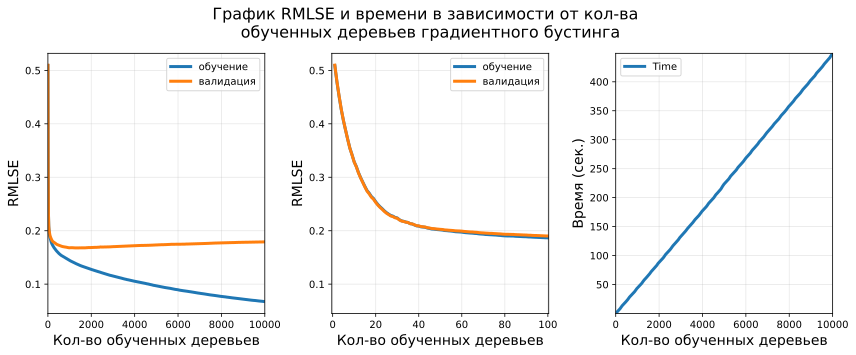

In [ ]:
val_data = np.array(history['val'])
train_data = np.array(history['train'])
time_data = np.array(history['time'])

count_trees = range(1, len(val_data) + 1)

fig, axes = plt.subplots(1, 3, figsize=(12, 5))

fig.suptitle("График RMLSE и времени в зависимости от кол-ва \n обученных деревьев градиентного бустинга", fontsize=16)
ax = axes[0]
ax.plot(count_trees, train_data, label='обучение', linewidth=3)
ax.plot(count_trees, val_data, label='валидация', linewidth=3)

ax.set_xlabel('Кол-во обученных деревьев', fontsize=14)
ax.set_ylabel('RMLSE', fontsize=14)

ax.set_xlim((-0.4, len(time_data) + 0.4))

ax.legend()
ax.grid(alpha=0.3)

ax = axes[1]
ax.plot(count_trees, train_data, label='обучение', linewidth=3)
ax.plot(count_trees, val_data, label='валидация', linewidth=3)

ax.set_xlabel('Кол-во обученных деревьев', fontsize=14)
ax.set_ylabel('RMLSE', fontsize=14)

ax.set_xlim((-0.4, 100 + 0.4))

ax.legend()
ax.grid(alpha=0.3)

ax = axes[2]
ax.plot(count_trees, time_data, label='Time', linewidth=3)

ax.set_xlabel('Кол-во обученных деревьев', fontsize=14)
ax.set_ylabel('Время (сек.)', fontsize=14)
ax.set_ylim((time_data.min(),time_data.max()))
ax.set_xlim((-0.4, len(time_data) + 0.4))
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()

fig.savefig("gb_n_estim.pdf")
plt.show()

### **Исследование в зависимости от гиперпараметра max_features**

In [ ]:
from tqdm import tqdm

max_features_history = {}

for max_features in tqdm(["sqrt", "log2", int(X_train_t.shape[1]/2), int(X_train_t.shape[1]/3), 10, 5, 2]):
  model = GradientBoostingMSE(n_estimators=10000, tree_params={
      "max_depth": 3, "max_features": max_features})

  index = str(max_features)

  max_features_history[index] = model.fit(X_train1, y_train1, patience=500, X_val=X_val, y_val=y_val)

100%|██████████| 7/7 [06:12<00:00, 53.23s/it]


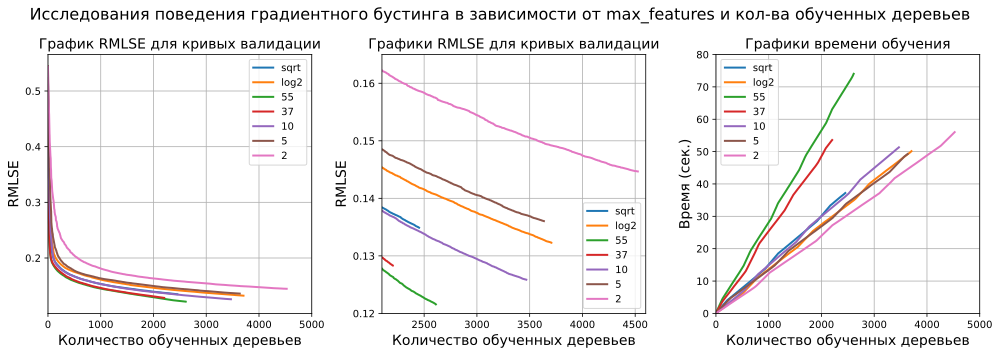

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

fig.suptitle("Исследования поведения градиентного бустинга в зависимости от max_features и кол-ва обученных деревьев", fontsize=16)
ax = axes[0]
ax.set_title("График RMLSE для кривых валидации", fontsize=14)

for index in max_features_history.keys():
  ax.plot(max_features_history[index]['train'], linewidth=2, label=index)

ax.set_xlabel("Количество обученных деревьев", fontsize=14)
ax.set_ylabel("RMLSE", fontsize=14)

ax.set_xlim((0, 5000))
ax.legend()
ax.grid()

ax = axes[1]
ax.set_title("Графики RMLSE для кривых валидации", fontsize=14)

for index in max_features_history.keys():
  ax.plot(max_features_history[index]['train'], linewidth=2, label=index)

ax.set_xlabel("Количество обученных деревьев", fontsize=14)
ax.set_ylabel("RMLSE", fontsize=14)
ax.set_xlim((2100 ,4600))
ax.set_ylim((0.12, 0.165))
ax.legend()
ax.grid()

ax = axes[2]
ax.set_title("Графики времени обучения", fontsize=14)

for index in max_features_history.keys():
  ax.plot(max_features_history[index]['time'], linewidth=2, label=index)

ax.set_xlabel("Количество обученных деревьев", fontsize=14)
ax.set_ylabel("Время (сек.)", fontsize=14)

ax.set_xlim((0, 5000))
ax.set_ylim((0, 80))
ax.legend()
ax.grid()

fig.savefig(fname='gb_rf_mf.pdf')

plt.tight_layout()
plt.show()

### **Исследование в зависимости от гиперпараметра max_depth**

In [ ]:
from tqdm import tqdm

max_depth_history = {}

for max_depth in tqdm([2, 3, 4, 5, 10]):
  model = GradientBoostingMSE(n_estimators=10000, tree_params={
      "max_depth": max_depth})

  index = str(max_depth)

  max_depth_history[index] = model.fit(X_train_t, y_train, patience=500, X_val=X_test_t, y_val=y_test)

100%|██████████| 5/5 [10:24<00:00, 124.98s/it]


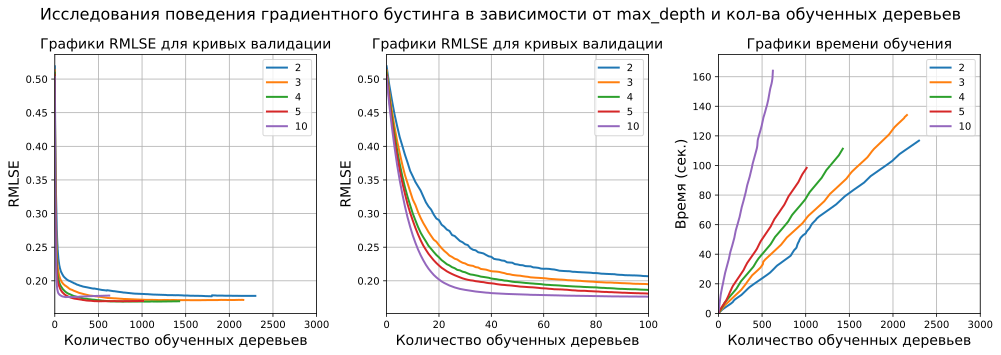

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

fig.suptitle("Исследования поведения градиентного бустинга в зависимости от max_depth и кол-ва обученных деревьев", fontsize=16)

ax = axes[0]
ax.set_title("Графики RMLSE для кривых валидации", fontsize=14)

for index in max_depth_history.keys():
  ax.plot(max_depth_history[index]['val'], linewidth=2, label=index)

ax.set_xlabel("Количество обученных деревьев", fontsize=14)
ax.set_ylabel("RMLSE", fontsize=14)
ax.set_xlim((0, 3000))
ax.legend()
ax.grid()

ax = axes[1]
ax.set_title("Графики RMLSE для кривых валидации", fontsize=14)

for index in max_depth_history.keys():
  ax.plot(max_depth_history[index]['val'], linewidth=2, label=index)

ax.set_xlabel("Количество обученных деревьев", fontsize=14)
ax.set_ylabel("RMLSE", fontsize=14)
ax.set_xlim((0 ,100))

ax.legend()
ax.grid()

ax = axes[2]
ax.set_title("Графики времени обучения", fontsize=14)

for index in max_depth_history.keys():
  ax.plot(max_depth_history[index]['time'], linewidth=2, label=index)

ax.set_xlabel("Количество обученных деревьев", fontsize=14)
ax.set_ylabel("Время (сек.)", fontsize=14)

ax.set_xlim((0, 3000))
ax.set_ylim((0, 175))
ax.legend()
ax.grid()

plt.savefig(fname='gb_rf_md.pdf')

plt.tight_layout()
plt.show()

### **Исследование при неограниченном max_depth**

In [ ]:
model = GradientBoostingMSE(n_estimators=10000, tree_params={
    "max_depth": None})

none_depth = model.fit(X_train_t, y_train, patience=500, X_val=X_test_t, y_val=y_test)

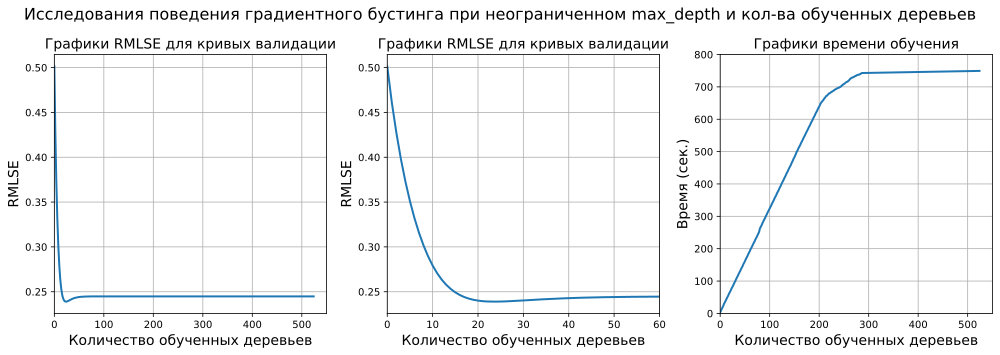

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

fig.suptitle("Исследования поведения градиентного бустинга при неограниченном max_depth и кол-ва обученных деревьев", fontsize=16)

ax = axes[0]
ax.set_title("Графики RMLSE для кривых валидации", fontsize=14)

ax.plot(none_depth['val'], linewidth=2, label=index)

ax.set_xlabel("Количество обученных деревьев", fontsize=14)
ax.set_ylabel("RMLSE", fontsize=14)
ax.set_xlim((0, 550))

ax.grid()

ax = axes[1]
ax.set_title("Графики RMLSE для кривых валидации", fontsize=14)

ax.plot(none_depth['val'], linewidth=2, label=index)

ax.set_xlabel("Количество обученных деревьев", fontsize=14)
ax.set_ylabel("RMLSE", fontsize=14)
ax.set_xlim((0 ,60))

ax.grid()

ax = axes[2]
ax.set_title("Графики времени обучения", fontsize=14)

ax.plot(none_depth['time'], linewidth=2, label=index)

ax.set_xlabel("Количество обученных деревьев", fontsize=14)
ax.set_ylabel("Время (сек.)", fontsize=14)

ax.set_xlim((0, 550))
ax.set_ylim((0, 800))
ax.grid()

plt.savefig(fname='gb_rf_nmd.pdf')

plt.tight_layout()
plt.show()

### **Исследование в зависимости от гиперпараметра learning_rate**

In [ ]:
from tqdm import tqdm

rate_history = {}

for rate in tqdm([0.01, 0.05, 0.1, 0.2, 0.3]):
  model = GradientBoostingMSE(n_estimators=1000, learning_rate=rate, tree_params={
      "max_depth": 3})

  index = str(rate)

  rate_history[index] = model.fit(X_train_t, y_train, patience=300, X_val=X_test_t, y_val=y_test)

100%|██████████| 5/5 [04:33<00:00, 54.78s/it]


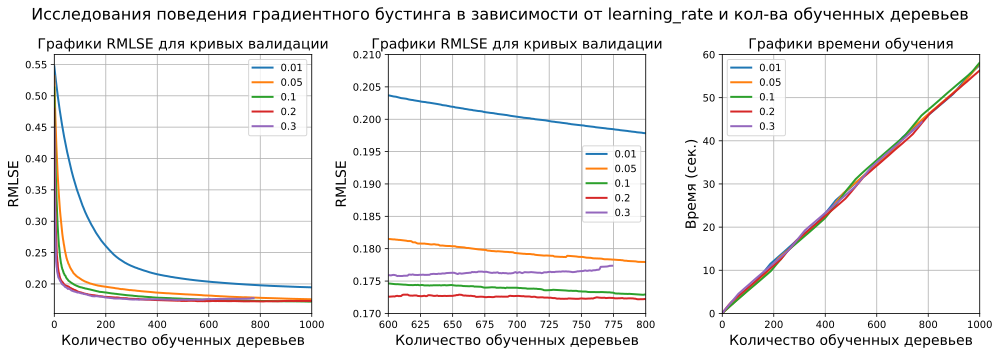

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

fig.suptitle("Исследования поведения градиентного бустинга в зависимости от learning_rate и кол-ва обученных деревьев", fontsize=16)

ax = axes[0]
ax.set_title("Графики RMLSE для кривых валидации", fontsize=14)

for index in rate_history.keys():
  ax.plot(rate_history[index]['val'], linewidth=2, label=index)

ax.set_xlabel("Количество обученных деревьев", fontsize=14)
ax.set_ylabel("RMLSE", fontsize=14)
ax.set_xlim((0, 1000))
ax.legend()
ax.grid()

ax = axes[1]
ax.set_title("Графики RMLSE для кривых валидации", fontsize=14)

for index in rate_history.keys():
  ax.plot(rate_history[index]['val'], linewidth=2, label=index)

ax.set_xlabel("Количество обученных деревьев", fontsize=14)
ax.set_ylabel("RMLSE", fontsize=14)
ax.set_xlim((600 ,800))
ax.set_ylim((0.17, 0.21))

ax.legend()
ax.grid()

ax = axes[2]
ax.set_title("Графики времени обучения", fontsize=14)

for index in rate_history.keys():
  ax.plot(rate_history[index]['time'], linewidth=2, label=index)

ax.set_xlabel("Количество обученных деревьев", fontsize=14)
ax.set_ylabel("Время (сек.)", fontsize=14)

ax.set_xlim((0, 1000))
ax.set_ylim((0, 60))
ax.legend()
ax.grid()

plt.savefig(fname='gb_lr.pdf')

plt.tight_layout()
plt.show()